In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
tf.compat.v1.disable_eager_execution()

import os
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

In [2]:
### Corresponds to grid point index (ny,nx) = (32,58)
costLon  = 240
costLat  = 50

nx = 90
ny = 40
nz = 15

mainDir = '/scratch2/shreyas/global_oce_latlon_4x4'

gridDir = mainDir + '/run_spinup/GRID'
latc = np.reshape(np.fromfile(gridDir + '/YC.data', 
                              dtype = '>f'), (ny, nx))
hfacc = np.reshape(np.fromfile(gridDir + '/hFacC.data', 
                              dtype = '>f'), (nz, ny, nx))

DataDirs = [mainDir + '/run_forward_50yr_dailydump_pk000059400/diags/untarred_output',
             mainDir + '/run_forward_50yr_dailydump_pk000061200/diags/untarred_output']

hFacC_mask = hfacc>0
hFacC_mask = hFacC_mask.astype(np.float32)
hFacC_mask = hFacC_mask[0]

latmask = latc >= -20
mask = hFacC_mask * latmask
wetpoints = np.nonzero(mask)

In [3]:
files_list_TS = []
files_list_2Datm = []
init_indices = [594001, 612001]
length_rec = 18000

for i in range(length_rec):
    index = init_indices[0] + i
    files_list_TS.append(DataDirs[0] + '/' + f'state3d_TS.0000{index:6d}.data')
    files_list_2Datm.append(DataDirs[0] + '/' + f'state2d_atm.0000{index:6d}.data')
for i in range(length_rec):
    index = init_indices[1] + i
    files_list_TS.append(DataDirs[1] + '/' + f'state3d_TS.0000{index:6d}.data')
    files_list_2Datm.append(DataDirs[1] + '/' + f'state2d_atm.0000{index:6d}.data')
    
nt = len(files_list_TS)
thetaSurf = np.zeros((nt, ny, nx))
saltSurf  = np.zeros((nt, ny, nx))
tauX      = np.zeros((nt, ny, nx))
tauY      = np.zeros((nt, ny, nx))
cost      = np.zeros((nt, 1))
                     
for i in range(len(files_list_TS)):
    thetaSurf[i] = np.reshape(np.fromfile(files_list_TS[i], dtype = '>f')[:nx*ny*nz],
                              (nz, ny, nx))[0]
    saltSurf[i]  = np.reshape(np.fromfile(files_list_TS[i], dtype = '>f')[nx*ny*nz:],
                              (nz, ny, nx))[0]
    tauX[i]      = np.reshape(np.fromfile(files_list_2Datm[i], dtype = '>f')[7*nx*ny:8*nx*ny],
                              (ny, nx))
    tauY[i]      = np.reshape(np.fromfile(files_list_2Datm[i], dtype = '>f')[8*nx*ny:9*nx*ny],
                              (ny, nx))

cost[:,0] = thetaSurf[:,32,58]

thetaSurfWet = thetaSurf[:, wetpoints[0], wetpoints[1]]
saltSurfWet = saltSurf[:, wetpoints[0], wetpoints[1]]
tauXWet = tauX[:, wetpoints[0], wetpoints[1]]
tauYWet = tauY[:, wetpoints[0], wetpoints[1]]
tauWet = np.concatenate((tauXWet,tauYWet), axis = 1)

In [4]:
def quickSetup(X, y, numVars, lrp_methods, lagSteps, baseAnalysis, numAnalysis, **NNkwargs):
    
    result = {}
    
    if lagSteps > 0:
        K = TrainFullyConnectedNN(X[:-lagSteps], y[lagSteps:], **NNkwargs)
        L = TrainLR(X[:-lagSteps], y[lagSteps:], y_ref = 0.0, fit_intercept = False)
    if lagSteps == 0:
        K = TrainFullyConnectedNN(X, y, **NNkwargs)
        L = TrainLR(X, y, y_ref = 0.0, fit_intercept = False)
        
    best_model = K.quickTrain()
    result['cost_predict_NN'] = best_model.predict(X)
    
    regr = L.quickTrain()
    result['cost_predict_LR'] = regr.predict(X)
    
    normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
    kwargs = {'y_ref': 0.00}

    
    
    for method in lrp_methods:
        
        print(f'Analyze using {method}')
        
        Xplain = XAIR(best_model, method, 'classic', X[baseAnalysis:baseAnalysis+numAnalysis], normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, numAnalysis, ny, nx))
        rel[:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1]] = a[:,numvar*perVar:(numvar+1)*perVar].T
        result[method] = rel
        
    print(f'Analyze using lrp.LR')
    
    XL = XLR(regr, X[baseAnalysis:baseAnalysis+numAnalysis])
    a_LR, _ = XL.quick_analyze()
    perVar = int(a_LR.shape[1]/numVars)
    
    rel_LR = np.zeros((numVars, numAnalysis, ny, nx))
    rel_LR[:,:,:,:] = np.nan

    for numvar in range(numVars):
        rel_LR[numvar,:,wetpoints[0],wetpoints[1]] = a_LR[:,numvar*perVar:(numvar+1)*perVar].T
    result['lrp.LR'] = rel_LR
        
    return result

In [5]:
LayersTheta = [{'size': thetaSurfWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 20                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
LayersSalt = [{'size': saltSurfWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 20                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
LayersTau = [{'size': tauWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 40                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

LRPDict_theta = {}
LRPDict_salt  = {}
LRPDict_tau   = {}
lagStepsList = [30, 60, 90, 120, 150, 180]

kwargs = {'losses': Losses, 'optim': 'adam', 'metrics': ['mae'],
            'batch_size': 10, 'epochs': 50, 'validation_split': 0.2,
            'filename': 'model', 'dirname': os.path.abspath('')}

for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Salt')
    LRPDict_salt[f'LRP{lagStepsList[i]}'] = quickSetup(saltSurfWet, cost, numVars = 1, lrp_methods = ['lrp.alpha_1_beta_0', 'lrp.z'],
                                                       lagSteps = lagStepsList[i], baseAnalysis = 0, numAnalysis = 360,
                                                       layers = LayersSalt, **kwargs)

Lag: 30 days, for Salt
Train on 28776 samples, validate on 7194 samples
Epoch 1/50
   10/28776 [..............................] - ETA: 4:52 - loss: 4806.8228 - mae: 69.3176

2023-08-17 18:56:37.209664: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-2.1.3/installation/lib:/share/jdk-16.0.1/lib::
2023-08-17 18:56:37.209708: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-17 18:56:37.209735: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c1-1): /proc/driver/nvidia/version does not exist
2023-08-17 18:56:37.210168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural N

28570/28776 [============================>.] - ETA: 0s - loss: 12.4396 - mae: 2.1677
Epoch 1: val_loss improved from inf to 30.02506, saving model to /home/shreyas/XAIRT/examples/model.h5
28776/28776 [==============================] - 5s 184us/sample - loss: 12.4535 - mae: 2.1756 - val_loss: 30.0251 - val_mae: 5.2914
Epoch 2/50
28470/28776 [============================>.] - ETA: 0s - loss: 5.5636 - mae: 1.8957
Epoch 2: val_loss improved from 30.02506 to 2.14319, saving model to /home/shreyas/XAIRT/examples/model.h5
28776/28776 [==============================] - 5s 178us/sample - loss: 5.5417 - mae: 1.8919 - val_loss: 2.1432 - val_mae: 1.2919
Epoch 3/50
28730/28776 [============================>.] - ETA: 0s - loss: 3.5295 - mae: 1.5469
Epoch 3: val_loss did not improve from 2.14319
28776/28776 [==============================] - 5s 162us/sample - loss: 3.5317 - mae: 1.5472 - val_loss: 6.7576 - val_mae: 2.1246
Epoch 4/50
28600/28776 [============================>.] - ETA: 0s - loss: 2.925

Epoch 28/50
28610/28776 [============================>.] - ETA: 0s - loss: 0.1242 - mae: 0.2787
Epoch 28: val_loss did not improve from 0.02759
28776/28776 [==============================] - 3s 121us/sample - loss: 0.1239 - mae: 0.2783 - val_loss: 0.0281 - val_mae: 0.1249
Epoch 29/50
28620/28776 [============================>.] - ETA: 0s - loss: 0.1212 - mae: 0.2777
Epoch 29: val_loss did not improve from 0.02759
28776/28776 [==============================] - 4s 123us/sample - loss: 0.1208 - mae: 0.2771 - val_loss: 0.1297 - val_mae: 0.3301
Epoch 30/50
28630/28776 [============================>.] - ETA: 0s - loss: 0.1116 - mae: 0.2652
Epoch 30: val_loss did not improve from 0.02759
28776/28776 [==============================] - 4s 124us/sample - loss: 0.1117 - mae: 0.2654 - val_loss: 0.0600 - val_mae: 0.2156
Epoch 31/50
28650/28776 [============================>.] - ETA: 0s - loss: 0.1102 - mae: 0.2644
Epoch 31: val_loss did not improve from 0.02759
28776/28776 [========================

28520/28752 [============================>.] - ETA: 0s - loss: 2.9882 - mae: 1.5207
Epoch 6: val_loss did not improve from 2.65693
28752/28752 [==============================] - 4s 153us/sample - loss: 2.9868 - mae: 1.5204 - val_loss: 3.4034 - val_mae: 1.5926
Epoch 7/50
28620/28752 [============================>.] - ETA: 0s - loss: 2.9917 - mae: 1.5178
Epoch 7: val_loss did not improve from 2.65693
28752/28752 [==============================] - 5s 157us/sample - loss: 2.9911 - mae: 1.5178 - val_loss: 2.6841 - val_mae: 1.4738
Epoch 8/50
28750/28752 [============================>.] - ETA: 0s - loss: 2.9234 - mae: 1.5034
Epoch 8: val_loss improved from 2.65693 to 2.64843, saving model to /home/shreyas/XAIRT/examples/model.h5
28752/28752 [==============================] - 4s 129us/sample - loss: 2.9234 - mae: 1.5034 - val_loss: 2.6484 - val_mae: 1.4624
Epoch 9/50
28560/28752 [============================>.] - ETA: 0s - loss: 2.8892 - mae: 1.4904
Epoch 9: val_loss did not improve from 2.648

28752/28752 [==============================] - 5s 190us/sample - loss: 0.1071 - mae: 0.2620 - val_loss: 0.0255 - val_mae: 0.1295
Epoch 34/50
28720/28752 [============================>.] - ETA: 0s - loss: 0.1054 - mae: 0.2601
Epoch 34: val_loss did not improve from 0.02552
28752/28752 [==============================] - 5s 178us/sample - loss: 0.1054 - mae: 0.2602 - val_loss: 0.0426 - val_mae: 0.1802
Epoch 35/50
28700/28752 [============================>.] - ETA: 0s - loss: 0.0970 - mae: 0.2498
Epoch 35: val_loss improved from 0.02552 to 0.02551, saving model to /home/shreyas/XAIRT/examples/model.h5
28752/28752 [==============================] - 4s 146us/sample - loss: 0.0970 - mae: 0.2498 - val_loss: 0.0255 - val_mae: 0.1403
Epoch 36/50
28400/28752 [============================>.] - ETA: 0s - loss: 0.0977 - mae: 0.2522
Epoch 36: val_loss did not improve from 0.02551
28752/28752 [==============================] - 4s 145us/sample - loss: 0.0991 - mae: 0.2539 - val_loss: 0.4423 - val_mae: 

Epoch 11/50
28340/28728 [============================>.] - ETA: 0s - loss: 2.1474 - mae: 1.2610
Epoch 11: val_loss did not improve from 2.28838
28728/28728 [==============================] - 4s 126us/sample - loss: 2.1466 - mae: 1.2603 - val_loss: 2.3948 - val_mae: 1.2388
Epoch 12/50
28560/28728 [============================>.] - ETA: 0s - loss: 1.7211 - mae: 1.1094
Epoch 12: val_loss improved from 2.28838 to 1.04459, saving model to /home/shreyas/XAIRT/examples/model.h5
28728/28728 [==============================] - 4s 124us/sample - loss: 1.7230 - mae: 1.1100 - val_loss: 1.0446 - val_mae: 0.9256
Epoch 13/50
28470/28728 [============================>.] - ETA: 0s - loss: 1.1609 - mae: 0.8910
Epoch 13: val_loss improved from 1.04459 to 0.59165, saving model to /home/shreyas/XAIRT/examples/model.h5
28728/28728 [==============================] - 4s 127us/sample - loss: 1.1598 - mae: 0.8906 - val_loss: 0.5917 - val_mae: 0.6624
Epoch 14/50
28350/28728 [============================>.] - ETA:

28700/28728 [============================>.] - ETA: 0s - loss: 0.0832 - mae: 0.2318
Epoch 39: val_loss did not improve from 0.01195
28728/28728 [==============================] - 4s 126us/sample - loss: 0.0832 - mae: 0.2318 - val_loss: 0.0214 - val_mae: 0.1178
Epoch 40/50
28580/28728 [============================>.] - ETA: 0s - loss: 0.0812 - mae: 0.2276
Epoch 40: val_loss did not improve from 0.01195
28728/28728 [==============================] - 4s 126us/sample - loss: 0.0810 - mae: 0.2272 - val_loss: 0.0181 - val_mae: 0.1093
Epoch 41/50
28700/28728 [============================>.] - ETA: 0s - loss: 0.0851 - mae: 0.2329
Epoch 41: val_loss did not improve from 0.01195
28728/28728 [==============================] - 4s 124us/sample - loss: 0.0850 - mae: 0.2329 - val_loss: 0.0437 - val_mae: 0.1836
Epoch 42/50
28480/28728 [============================>.] - ETA: 0s - loss: 0.0800 - mae: 0.2262
Epoch 42: val_loss did not improve from 0.01195
28728/28728 [==============================] - 4s

28704/28704 [==============================] - 4s 123us/sample - loss: 0.3385 - mae: 0.4674 - val_loss: 0.1494 - val_mae: 0.3278
Epoch 17/50
28610/28704 [============================>.] - ETA: 0s - loss: 0.3125 - mae: 0.4525
Epoch 17: val_loss did not improve from 0.14937
28704/28704 [==============================] - 4s 123us/sample - loss: 0.3121 - mae: 0.4521 - val_loss: 0.2110 - val_mae: 0.3864
Epoch 18/50
28480/28704 [============================>.] - ETA: 0s - loss: 0.2875 - mae: 0.4308
Epoch 18: val_loss did not improve from 0.14937
28704/28704 [==============================] - 4s 125us/sample - loss: 0.2863 - mae: 0.4297 - val_loss: 0.1671 - val_mae: 0.3309
Epoch 19/50
28580/28704 [============================>.] - ETA: 0s - loss: 0.2456 - mae: 0.3976
Epoch 19: val_loss improved from 0.14937 to 0.09859, saving model to /home/shreyas/XAIRT/examples/model.h5
28704/28704 [==============================] - 4s 134us/sample - loss: 0.2451 - mae: 0.3972 - val_loss: 0.0986 - val_mae: 

28490/28704 [============================>.] - ETA: 0s - loss: 0.0776 - mae: 0.2218
Epoch 45: val_loss did not improve from 0.02005
28704/28704 [==============================] - 4s 132us/sample - loss: 0.0774 - mae: 0.2216 - val_loss: 0.1689 - val_mae: 0.3915
Epoch 46/50
28430/28704 [============================>.] - ETA: 0s - loss: 0.0764 - mae: 0.2218
Epoch 46: val_loss did not improve from 0.02005
28704/28704 [==============================] - 5s 182us/sample - loss: 0.0767 - mae: 0.2223 - val_loss: 0.0307 - val_mae: 0.1445
Epoch 47/50
28690/28704 [============================>.] - ETA: 0s - loss: 0.0772 - mae: 0.2237
Epoch 47: val_loss did not improve from 0.02005
28704/28704 [==============================] - 6s 196us/sample - loss: 0.0772 - mae: 0.2237 - val_loss: 0.1373 - val_mae: 0.3505
Epoch 48/50
28690/28704 [============================>.] - ETA: 0s - loss: 0.0784 - mae: 0.2238
Epoch 48: val_loss improved from 0.02005 to 0.01871, saving model to /home/shreyas/XAIRT/examples

28440/28680 [============================>.] - ETA: 0s - loss: 0.1480 - mae: 0.3087
Epoch 22: val_loss did not improve from 0.05042
28680/28680 [==============================] - 4s 125us/sample - loss: 0.1508 - mae: 0.3112 - val_loss: 0.1924 - val_mae: 0.3899
Epoch 23/50
28540/28680 [============================>.] - ETA: 0s - loss: 0.1404 - mae: 0.2998
Epoch 23: val_loss did not improve from 0.05042
28680/28680 [==============================] - 4s 127us/sample - loss: 0.1405 - mae: 0.2999 - val_loss: 0.3496 - val_mae: 0.5597
Epoch 24/50
28620/28680 [============================>.] - ETA: 0s - loss: 0.1393 - mae: 0.2988
Epoch 24: val_loss did not improve from 0.05042
28680/28680 [==============================] - 5s 188us/sample - loss: 0.1392 - mae: 0.2987 - val_loss: 0.4236 - val_mae: 0.6216
Epoch 25/50
28650/28680 [============================>.] - ETA: 0s - loss: 0.1413 - mae: 0.3026
Epoch 25: val_loss did not improve from 0.05042
28680/28680 [==============================] - 5s

Epoch 1/50
28300/28656 [============================>.] - ETA: 0s - loss: 32.2473 - mae: 2.4346
Epoch 1: val_loss improved from inf to 4.26042, saving model to /home/shreyas/XAIRT/examples/model.h5
28656/28656 [==============================] - 4s 137us/sample - loss: 31.9552 - mae: 2.4345 - val_loss: 4.2604 - val_mae: 1.6405
Epoch 2/50
28656/28656 [==============================] - ETA: 0s - loss: 6.7164 - mae: 2.0796
Epoch 2: val_loss improved from 4.26042 to 1.88267, saving model to /home/shreyas/XAIRT/examples/model.h5
28656/28656 [==============================] - 5s 162us/sample - loss: 6.7164 - mae: 2.0796 - val_loss: 1.8827 - val_mae: 1.1435
Epoch 3/50
28320/28656 [============================>.] - ETA: 0s - loss: 4.1031 - mae: 1.6278
Epoch 3: val_loss did not improve from 1.88267
28656/28656 [==============================] - 5s 176us/sample - loss: 4.0944 - mae: 1.6260 - val_loss: 3.5473 - val_mae: 1.5619
Epoch 4/50
28480/28656 [============================>.] - ETA: 0s - los

28390/28656 [============================>.] - ETA: 0s - loss: 0.1299 - mae: 0.2882
Epoch 28: val_loss did not improve from 0.02922
28656/28656 [==============================] - 5s 184us/sample - loss: 0.1294 - mae: 0.2876 - val_loss: 0.0862 - val_mae: 0.2469
Epoch 29/50
28410/28656 [============================>.] - ETA: 0s - loss: 0.1284 - mae: 0.2865
Epoch 29: val_loss did not improve from 0.02922
28656/28656 [==============================] - 5s 166us/sample - loss: 0.1287 - mae: 0.2871 - val_loss: 0.0307 - val_mae: 0.1515
Epoch 30/50
28370/28656 [============================>.] - ETA: 0s - loss: 0.1225 - mae: 0.2792
Epoch 30: val_loss did not improve from 0.02922
28656/28656 [==============================] - 4s 126us/sample - loss: 0.1242 - mae: 0.2810 - val_loss: 0.1471 - val_mae: 0.3466
Epoch 31/50
28460/28656 [============================>.] - ETA: 0s - loss: 0.1294 - mae: 0.2848
Epoch 31: val_loss did not improve from 0.02922
28656/28656 [==============================] - 4s

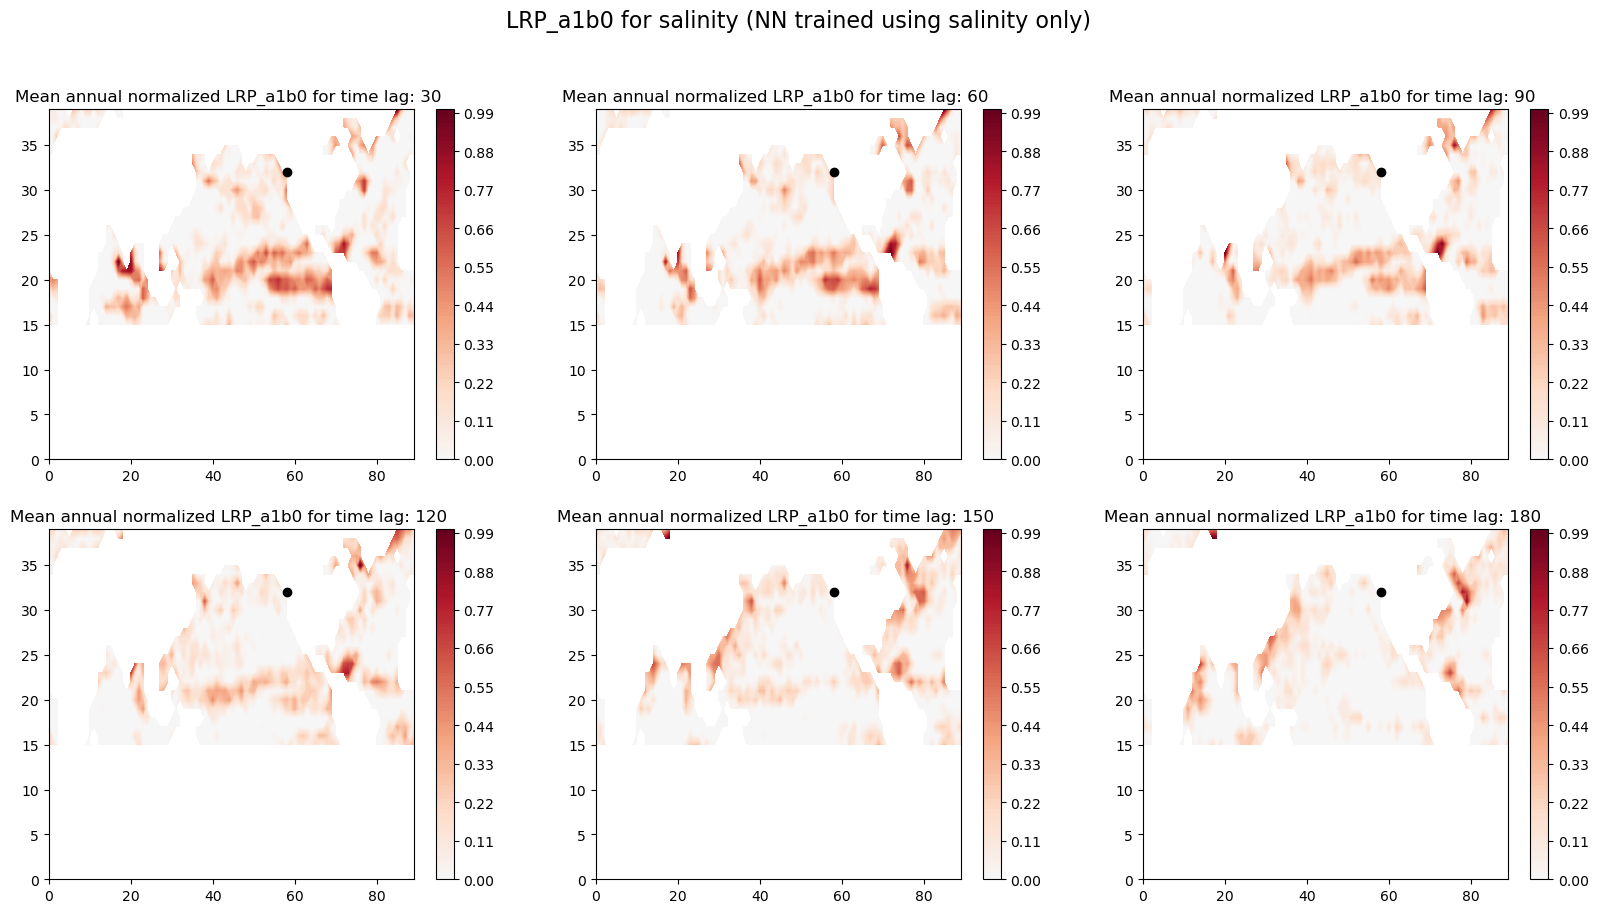

In [21]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_a1b0 for salinity (NN trained using salinity only)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_salt[f'LRP{lagStepsList[i]}']['lrp.alpha_1_beta_0'][0], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_a1b0 for time lag: {lagStepsList[i]} ')

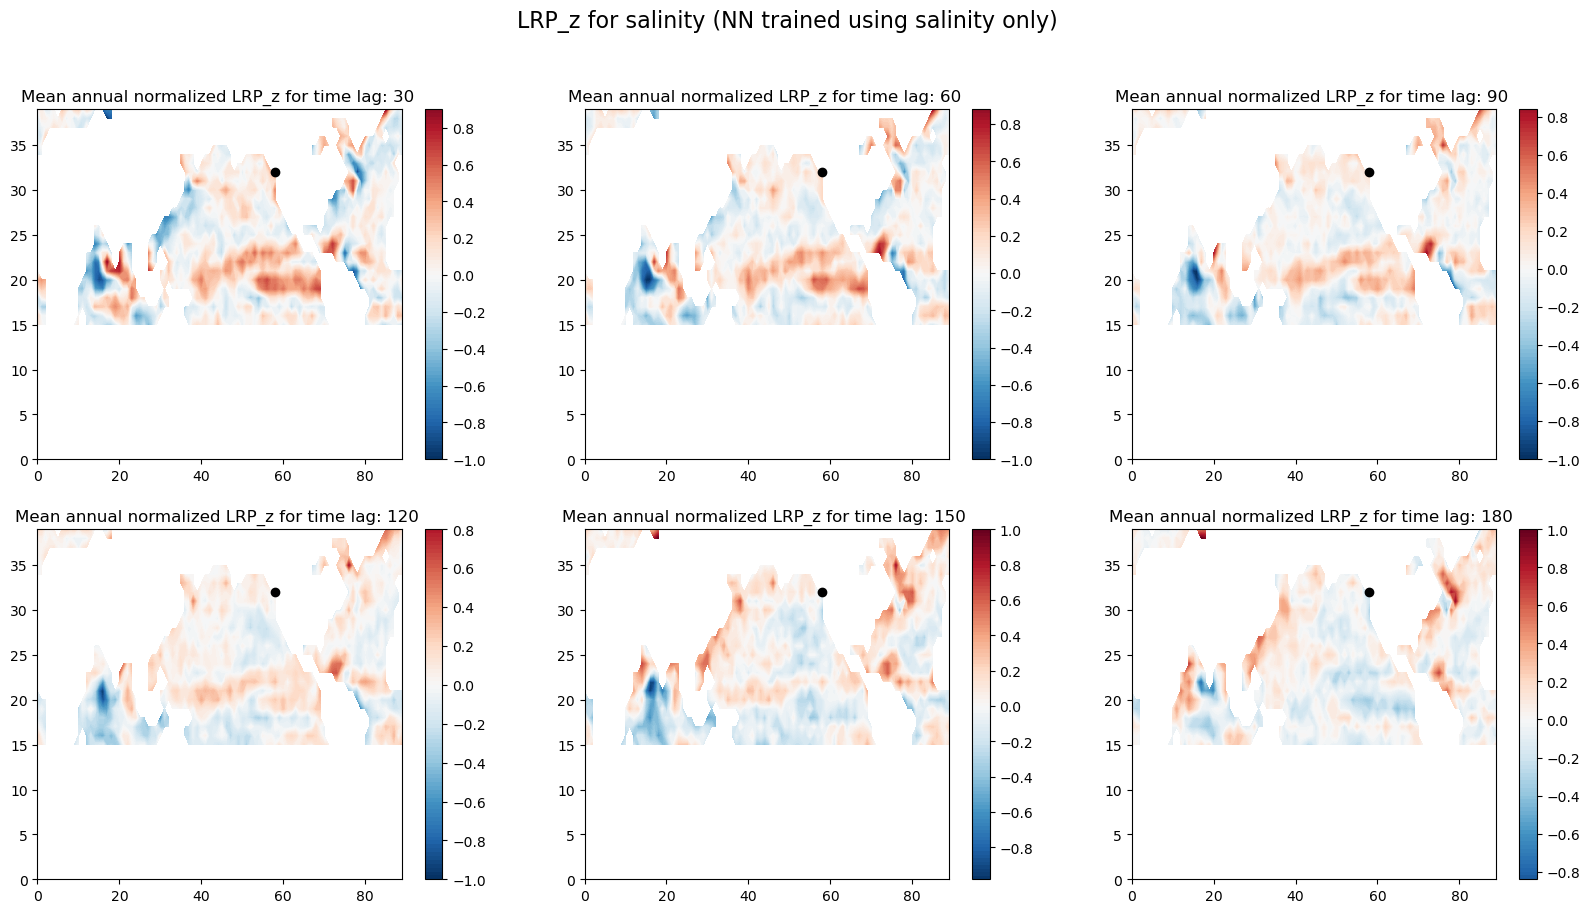

In [22]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_z for salinity (NN trained using salinity only)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_salt[f'LRP{lagStepsList[i]}']['lrp.z'][0], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_z for time lag: {lagStepsList[i]} ')

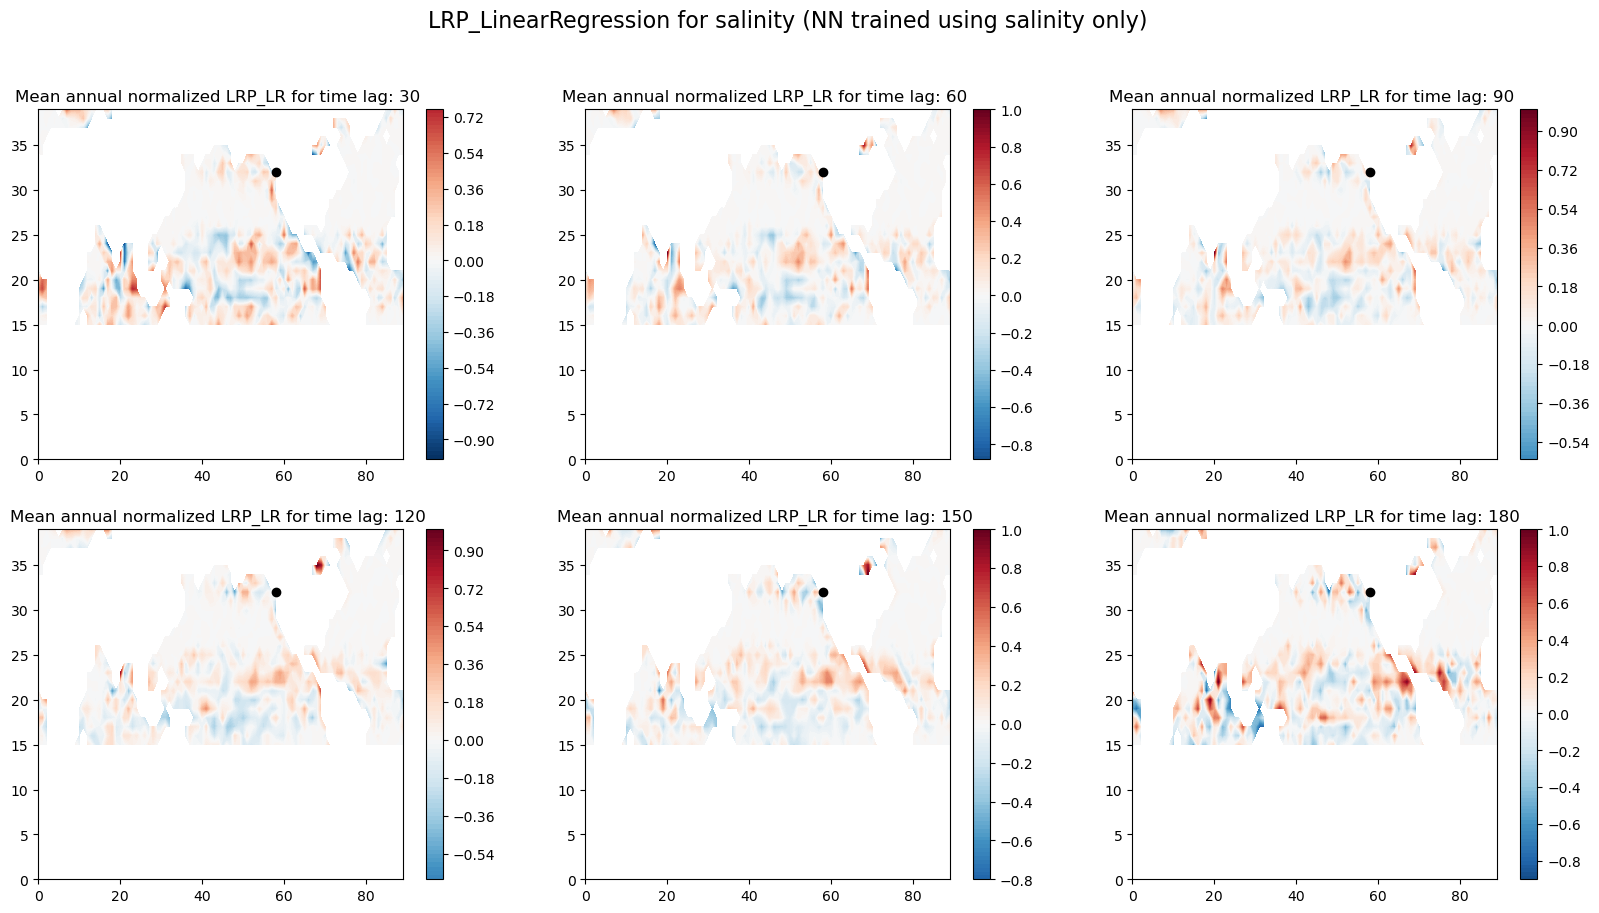

In [23]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_LinearRegression for salinity (NN trained using salinity only)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_salt[f'LRP{lagStepsList[i]}']['lrp.LR'][0], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_LR for time lag: {lagStepsList[i]} ')

In [24]:
LayersTheta = [{'size': thetaSurfWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 20                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
LayersSalt = [{'size': saltSurfWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 20                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
LayersTau = [{'size': tauWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 40                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

LRPDict_theta = {}
LRPDict_salt  = {}
LRPDict_tau   = {}
lagStepsList = [30, 60, 90, 120, 150, 180]

kwargs = {'losses': Losses, 'optim': 'adam', 'metrics': ['mae'],
            'batch_size': 10, 'epochs': 50, 'validation_split': 0.2,
            'filename': 'model', 'dirname': os.path.abspath('')}

for i in range(len(lagStepsList)):
    
    print(f'Lag: {lagStepsList[i]} days, for Theta')
    LRPDict_theta[f'LRP{lagStepsList[i]}'] = quickSetup(thetaSurfWet, cost, numVars = 1, lrp_methods = ['lrp.alpha_1_beta_0', 'lrp.z'],
                                                        lagSteps = lagStepsList[i], baseAnalysis = 0, numAnalysis = 360,
                                                        layers = LayersTheta, **kwargs)

Lag: 30 days, for Theta
Train on 28776 samples, validate on 7194 samples
Epoch 1/50
28730/28776 [============================>.] - ETA: 0s - loss: 133.2789 - mae: 11.3961
Epoch 1: val_loss improved from inf to 132.46064, saving model to /home/shreyas/XAIRT/examples/model.h5
28776/28776 [==============================] - 6s 207us/sample - loss: 133.2810 - mae: 11.3962 - val_loss: 132.4606 - val_mae: 11.3865
Epoch 2/50
28750/28776 [============================>.] - ETA: 0s - loss: 132.4865 - mae: 11.3876
Epoch 2: val_loss did not improve from 132.46064
28776/28776 [==============================] - 5s 169us/sample - loss: 132.4720 - mae: 11.3870 - val_loss: 132.4606 - val_mae: 11.3865
Epoch 3/50
28430/28776 [============================>.] - ETA: 0s - loss: 132.4820 - mae: 11.3874
Epoch 3: val_loss did not improve from 132.46064
28776/28776 [==============================] - 5s 164us/sample - loss: 132.4720 - mae: 11.3870 - val_loss: 132.4606 - val_mae: 11.3865
Epoch 4/50
28470/28776 [==

Epoch 29/50
28500/28776 [============================>.] - ETA: 0s - loss: 132.4807 - mae: 11.3874
Epoch 29: val_loss did not improve from 132.46064
28776/28776 [==============================] - 5s 160us/sample - loss: 132.4720 - mae: 11.3870 - val_loss: 132.4606 - val_mae: 11.3865
Epoch 30/50
28600/28776 [============================>.] - ETA: 0s - loss: 132.4668 - mae: 11.3868
Epoch 30: val_loss did not improve from 132.46064
28776/28776 [==============================] - 4s 126us/sample - loss: 132.4720 - mae: 11.3870 - val_loss: 132.4606 - val_mae: 11.3865
Epoch 31/50
28560/28776 [============================>.] - ETA: 0s - loss: 132.4676 - mae: 11.3868
Epoch 31: val_loss did not improve from 132.46064
28776/28776 [==============================] - 4s 129us/sample - loss: 132.4720 - mae: 11.3870 - val_loss: 132.4606 - val_mae: 11.3865
Epoch 32/50
28580/28776 [============================>.] - ETA: 0s - loss: 132.4746 - mae: 11.3870
Epoch 32: val_loss did not improve from 132.46064

Epoch 7/50
28390/28752 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0661
Epoch 7: val_loss improved from 0.00188 to 0.00120, saving model to /home/shreyas/XAIRT/examples/model.h5
28752/28752 [==============================] - 4s 132us/sample - loss: 0.0070 - mae: 0.0659 - val_loss: 0.0012 - val_mae: 0.0291
Epoch 8/50
28580/28752 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0629
Epoch 8: val_loss did not improve from 0.00120
28752/28752 [==============================] - 5s 167us/sample - loss: 0.0064 - mae: 0.0630 - val_loss: 0.0020 - val_mae: 0.0368
Epoch 9/50
28400/28752 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0612
Epoch 9: val_loss improved from 0.00120 to 0.00097, saving model to /home/shreyas/XAIRT/examples/model.h5
28752/28752 [==============================] - 4s 151us/sample - loss: 0.0059 - mae: 0.0609 - val_loss: 9.6891e-04 - val_mae: 0.0244
Epoch 10/50
28440/28752 [============================>.] - ETA: 0

28750/28752 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0302
Epoch 36: val_loss did not improve from 0.00016
28752/28752 [==============================] - 5s 167us/sample - loss: 0.0015 - mae: 0.0302 - val_loss: 0.0016 - val_mae: 0.0387
Epoch 37/50
28740/28752 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0305
Epoch 37: val_loss did not improve from 0.00016
28752/28752 [==============================] - 4s 145us/sample - loss: 0.0015 - mae: 0.0305 - val_loss: 0.0011 - val_mae: 0.0310
Epoch 38/50
28752/28752 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0311
Epoch 38: val_loss did not improve from 0.00016
28752/28752 [==============================] - 4s 126us/sample - loss: 0.0016 - mae: 0.0311 - val_loss: 0.0012 - val_mae: 0.0327
Epoch 39/50
28390/28752 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0293
Epoch 39: val_loss improved from 0.00016 to 0.00010, saving model to /home/shreyas/XAIRT/examples

28580/28728 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0641
Epoch 14: val_loss did not improve from 0.00074
28728/28728 [==============================] - 4s 124us/sample - loss: 0.0067 - mae: 0.0641 - val_loss: 0.0100 - val_mae: 0.0954
Epoch 15/50
28660/28728 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0614
Epoch 15: val_loss improved from 0.00074 to 0.00053, saving model to /home/shreyas/XAIRT/examples/model.h5
28728/28728 [==============================] - 4s 124us/sample - loss: 0.0062 - mae: 0.0613 - val_loss: 5.3384e-04 - val_mae: 0.0187
Epoch 16/50
28728/28728 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0585
Epoch 16: val_loss did not improve from 0.00053
28728/28728 [==============================] - 4s 124us/sample - loss: 0.0058 - mae: 0.0585 - val_loss: 0.0066 - val_mae: 0.0790
Epoch 17/50
28330/28728 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0566
Epoch 17: val_loss did not improve

Epoch 43/50
28380/28728 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0315
Epoch 43: val_loss did not improve from 0.00010
28728/28728 [==============================] - 5s 160us/sample - loss: 0.0018 - mae: 0.0314 - val_loss: 1.2691e-04 - val_mae: 0.0095
Epoch 44/50
28350/28728 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0321
Epoch 44: val_loss did not improve from 0.00010
28728/28728 [==============================] - 4s 124us/sample - loss: 0.0018 - mae: 0.0321 - val_loss: 0.0015 - val_mae: 0.0373
Epoch 45/50
28270/28728 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0338
Epoch 45: val_loss did not improve from 0.00010
28728/28728 [==============================] - 4s 124us/sample - loss: 0.0019 - mae: 0.0335 - val_loss: 0.0018 - val_mae: 0.0410
Epoch 46/50
28728/28728 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0306
Epoch 46: val_loss did not improve from 0.00010
28728/28728 [====================

Epoch 21/50
28280/28704 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0467
Epoch 21: val_loss improved from 0.00055 to 0.00054, saving model to /home/shreyas/XAIRT/examples/model.h5
28704/28704 [==============================] - 4s 126us/sample - loss: 0.0036 - mae: 0.0467 - val_loss: 5.3824e-04 - val_mae: 0.0198
Epoch 22/50
28520/28704 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0455
Epoch 22: val_loss did not improve from 0.00054
28704/28704 [==============================] - 4s 128us/sample - loss: 0.0034 - mae: 0.0457 - val_loss: 0.0183 - val_mae: 0.1331
Epoch 23/50
28280/28704 [============================>.] - ETA: 0s - loss: 0.0032 - mae: 0.0449
Epoch 23: val_loss improved from 0.00054 to 0.00019, saving model to /home/shreyas/XAIRT/examples/model.h5
28704/28704 [==============================] - 4s 127us/sample - loss: 0.0033 - mae: 0.0453 - val_loss: 1.9115e-04 - val_mae: 0.0099
Epoch 24/50
28410/28704 [============================>.

28704/28704 [==============================] - 4s 129us/sample - loss: 0.0017 - mae: 0.0306 - val_loss: 0.0120 - val_mae: 0.1081
Epoch 50/50
28580/28704 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0303
Epoch 50: val_loss did not improve from 0.00006
28704/28704 [==============================] - 4s 129us/sample - loss: 0.0016 - mae: 0.0302 - val_loss: 4.2634e-04 - val_mae: 0.0194
Analyze using lrp.alpha_1_beta_0
Analyze using lrp.z
Analyze using lrp.LR
Lag: 150 days, for Theta
Train on 28680 samples, validate on 7170 samples
Epoch 1/50
28240/28680 [============================>.] - ETA: 0s - loss: 5.7794 - mae: 0.7141
Epoch 1: val_loss improved from inf to 2.94189, saving model to /home/shreyas/XAIRT/examples/model.h5
28680/28680 [==============================] - 4s 130us/sample - loss: 5.7061 - mae: 0.7152 - val_loss: 2.9419 - val_mae: 1.7100
Epoch 2/50
28470/28680 [============================>.] - ETA: 0s - loss: 1.7586 - mae: 0.7892
Epoch 2: val_loss improve

28680/28680 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0434
Epoch 27: val_loss improved from 0.00035 to 0.00030, saving model to /home/shreyas/XAIRT/examples/model.h5
28680/28680 [==============================] - 5s 183us/sample - loss: 0.0030 - mae: 0.0434 - val_loss: 3.0374e-04 - val_mae: 0.0146
Epoch 28/50
28480/28680 [============================>.] - ETA: 0s - loss: 0.0029 - mae: 0.0421
Epoch 28: val_loss improved from 0.00030 to 0.00024, saving model to /home/shreyas/XAIRT/examples/model.h5
28680/28680 [==============================] - 5s 181us/sample - loss: 0.0028 - mae: 0.0421 - val_loss: 2.4009e-04 - val_mae: 0.0116
Epoch 29/50
28610/28680 [============================>.] - ETA: 0s - loss: 0.0027 - mae: 0.0394
Epoch 29: val_loss improved from 0.00024 to 0.00021, saving model to /home/shreyas/XAIRT/examples/model.h5
28680/28680 [==============================] - 5s 178us/sample - loss: 0.0027 - mae: 0.0395 - val_loss: 2.1222e-04 - val_mae: 0.0115
Epoc

Epoch 5/50
28470/28656 [============================>.] - ETA: 0s - loss: 0.0270 - mae: 0.1228
Epoch 5: val_loss did not improve from 0.01635
28656/28656 [==============================] - 5s 161us/sample - loss: 0.0275 - mae: 0.1238 - val_loss: 0.0226 - val_mae: 0.1482
Epoch 6/50
28460/28656 [============================>.] - ETA: 0s - loss: 0.0224 - mae: 0.1120
Epoch 6: val_loss improved from 0.01635 to 0.00273, saving model to /home/shreyas/XAIRT/examples/model.h5
28656/28656 [==============================] - 4s 125us/sample - loss: 0.0225 - mae: 0.1123 - val_loss: 0.0027 - val_mae: 0.0429
Epoch 7/50
28530/28656 [============================>.] - ETA: 0s - loss: 0.0176 - mae: 0.0991
Epoch 7: val_loss did not improve from 0.00273
28656/28656 [==============================] - 4s 155us/sample - loss: 0.0177 - mae: 0.0994 - val_loss: 0.0200 - val_mae: 0.1362
Epoch 8/50
28480/28656 [============================>.] - ETA: 0s - loss: 0.0137 - mae: 0.0894
Epoch 8: val_loss did not improve

Epoch 34/50
28270/28656 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0261
Epoch 34: val_loss did not improve from 0.00006
28656/28656 [==============================] - 3s 119us/sample - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0025 - val_mae: 0.0500
Epoch 35/50
28350/28656 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0273
Epoch 35: val_loss did not improve from 0.00006
28656/28656 [==============================] - 4s 125us/sample - loss: 0.0013 - mae: 0.0271 - val_loss: 2.2689e-04 - val_mae: 0.0141
Epoch 36/50
28350/28656 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0247
Epoch 36: val_loss did not improve from 0.00006
28656/28656 [==============================] - 3s 120us/sample - loss: 0.0011 - mae: 0.0248 - val_loss: 4.9064e-04 - val_mae: 0.0213
Epoch 37/50
28600/28656 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0260
Epoch 37: val_loss did not improve from 0.00006
28656/28656 [================

In [27]:
LRPDict_theta[f'LRP30'] = quickSetup(thetaSurfWet, cost, numVars = 1, lrp_methods = ['lrp.alpha_1_beta_0', 'lrp.z'],
                                                        lagSteps = 30, baseAnalysis = 0, numAnalysis = 360,
                                                        layers = LayersTheta, **kwargs)

Train on 28776 samples, validate on 7194 samples
Epoch 1/50
28750/28776 [============================>.] - ETA: 0s - loss: 1.1909 - mae: 0.3816
Epoch 1: val_loss improved from inf to 0.10609, saving model to /home/shreyas/XAIRT/examples/model.h5
28776/28776 [==============================] - 5s 177us/sample - loss: 1.1901 - mae: 0.3817 - val_loss: 0.1061 - val_mae: 0.3229
Epoch 2/50
28770/28776 [============================>.] - ETA: 0s - loss: 0.3106 - mae: 0.3278
Epoch 2: val_loss improved from 0.10609 to 0.03210, saving model to /home/shreyas/XAIRT/examples/model.h5
28776/28776 [==============================] - 5s 171us/sample - loss: 0.3106 - mae: 0.3278 - val_loss: 0.0321 - val_mae: 0.1755
Epoch 3/50
28700/28776 [============================>.] - ETA: 0s - loss: 0.1299 - mae: 0.2305
Epoch 3: val_loss improved from 0.03210 to 0.02125, saving model to /home/shreyas/XAIRT/examples/model.h5
28776/28776 [==============================] - 5s 169us/sample - loss: 0.1296 - mae: 0.2302 - 

Epoch 29/50
28530/28776 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0201
Epoch 29: val_loss did not improve from 0.00001
28776/28776 [==============================] - 4s 134us/sample - loss: 0.0012 - mae: 0.0201 - val_loss: 9.8906e-05 - val_mae: 0.0094
Epoch 30/50
28690/28776 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0228
Epoch 30: val_loss did not improve from 0.00001
28776/28776 [==============================] - 4s 127us/sample - loss: 0.0010 - mae: 0.0229 - val_loss: 2.1437e-04 - val_mae: 0.0143
Epoch 31/50
28440/28776 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0216
Epoch 31: val_loss did not improve from 0.00001
28776/28776 [==============================] - 4s 125us/sample - loss: 0.0011 - mae: 0.0214 - val_loss: 3.5634e-05 - val_mae: 0.0054
Epoch 32/50
28776/28776 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0207
Epoch 32: val_loss did not improve from 0.00001
28776/28776 [============

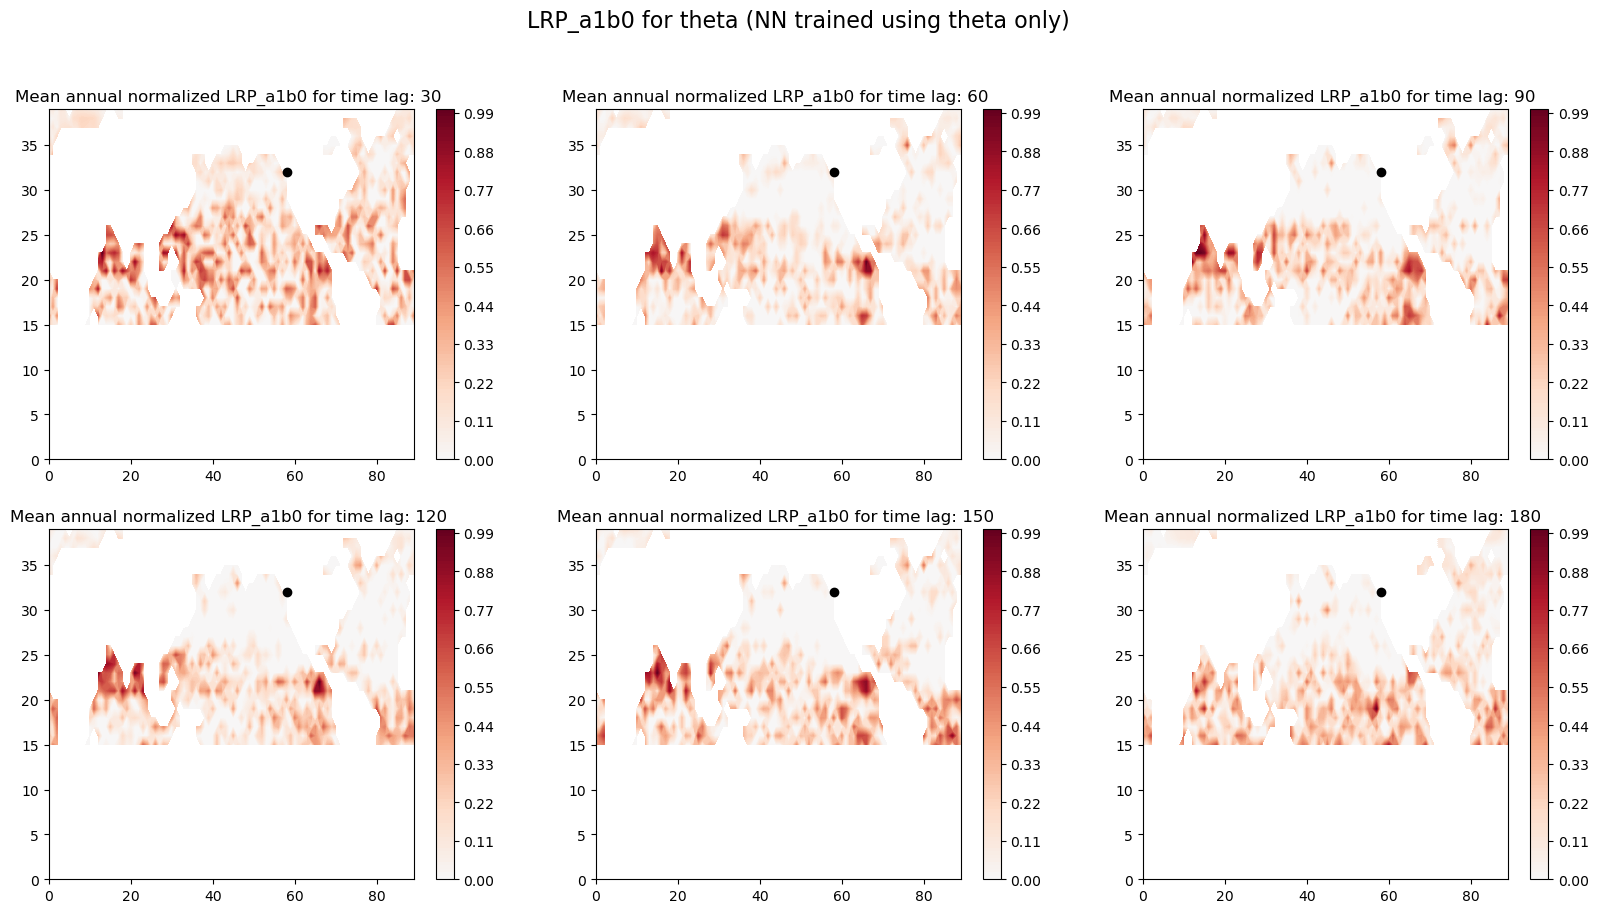

In [28]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_a1b0 for theta (NN trained using theta only)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_theta[f'LRP{lagStepsList[i]}']['lrp.alpha_1_beta_0'][0], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_a1b0 for time lag: {lagStepsList[i]} ')

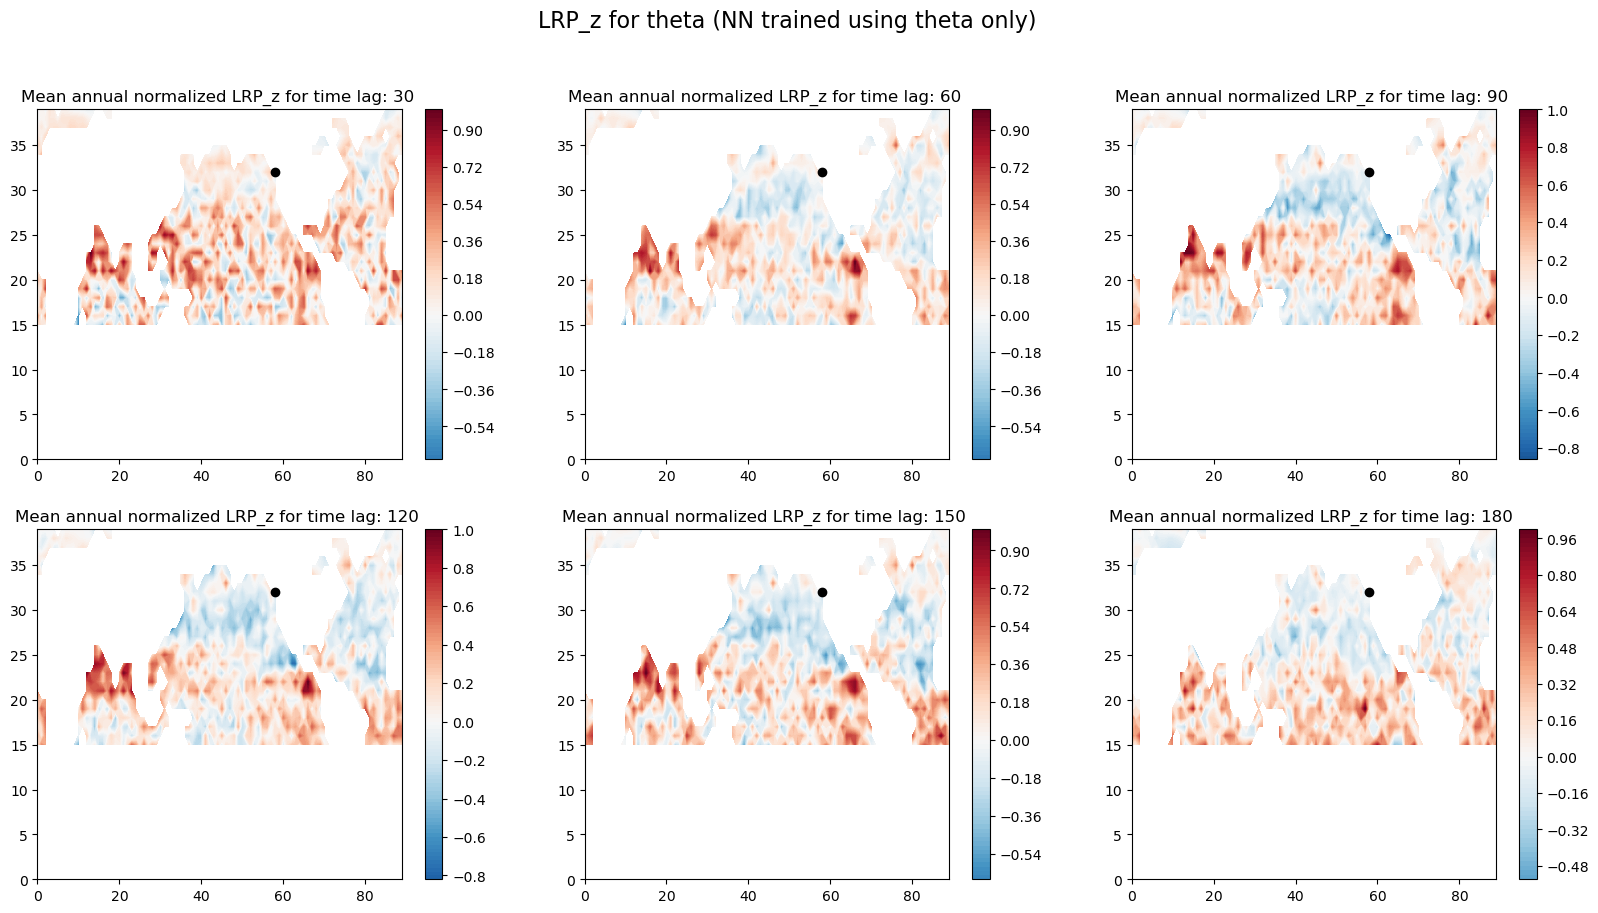

In [29]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_z for theta (NN trained using theta only)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_theta[f'LRP{lagStepsList[i]}']['lrp.z'][0], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_z for time lag: {lagStepsList[i]} ')

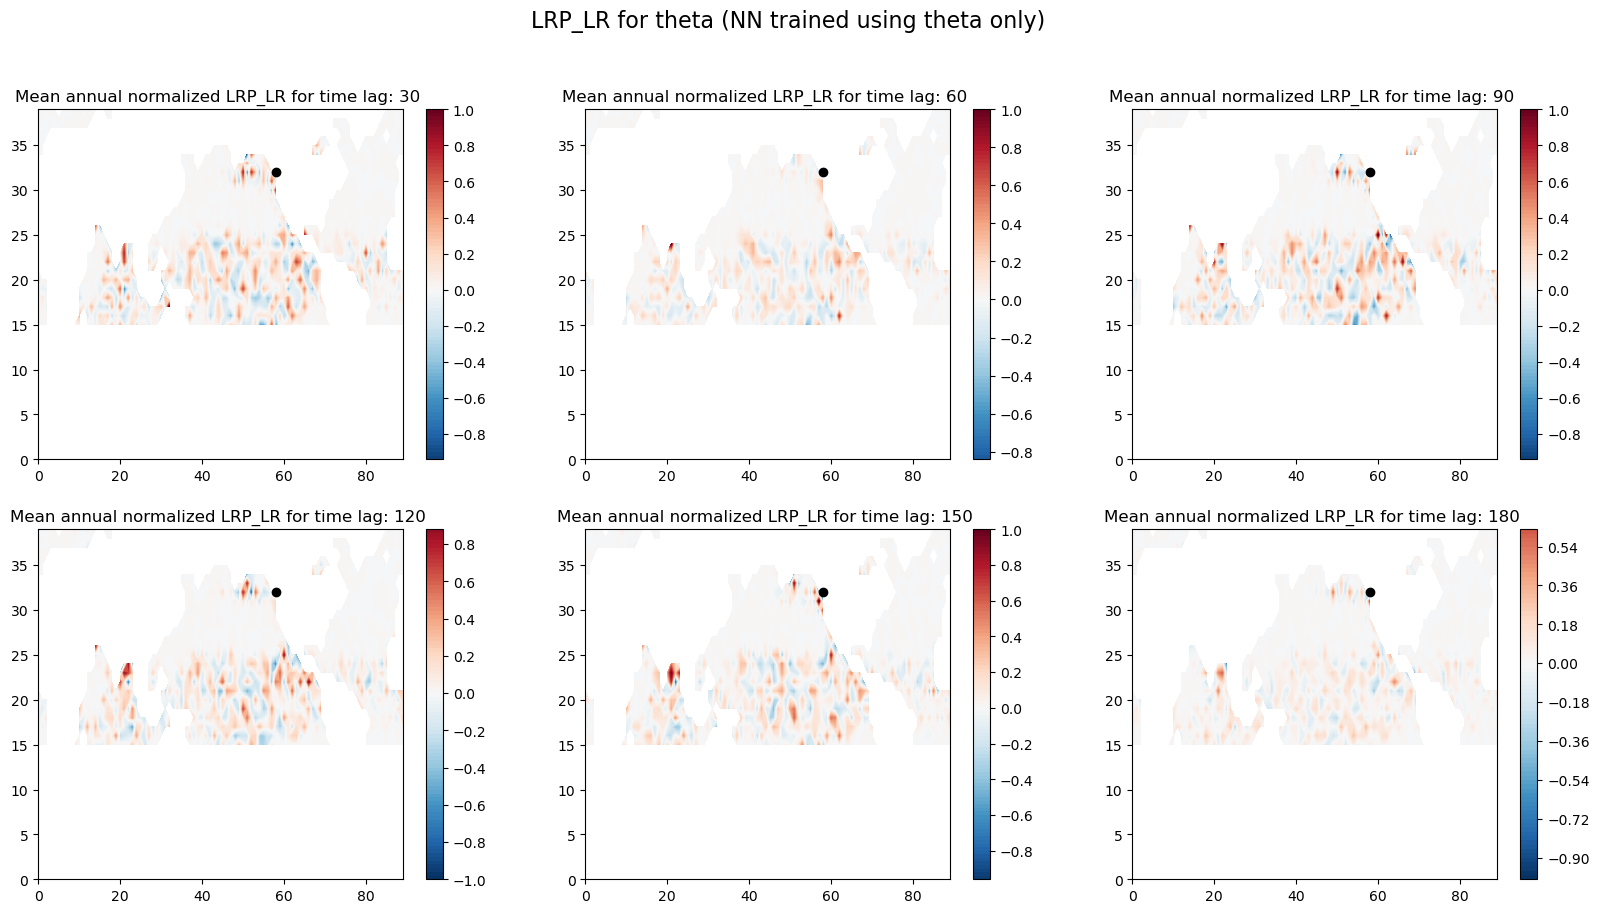

In [30]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_LR for theta (NN trained using theta only)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_theta[f'LRP{lagStepsList[i]}']['lrp.LR'][0], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_LR for time lag: {lagStepsList[i]} ')

In [31]:
LayersTheta = [{'size': thetaSurfWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 20                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
LayersSalt = [{'size': saltSurfWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 20                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
LayersTau = [{'size': tauWet.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 40                   , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1                    , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

LRPDict_theta = {}
LRPDict_salt  = {}
LRPDict_tau   = {}
lagStepsList = [30, 60, 90, 120, 150, 180]

kwargs = {'losses': Losses, 'optim': 'adam', 'metrics': ['mae'],
            'batch_size': 10, 'epochs': 50, 'validation_split': 0.2,
            'filename': 'model', 'dirname': os.path.abspath('')}

for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Tau')
    LRPDict_tau[f'LRP{lagStepsList[i]}'] = quickSetup(tauWet, cost, numVars = 2, lrp_methods = ['lrp.alpha_1_beta_0', 'lrp.z'],
                                                      lagSteps = lagStepsList[i], baseAnalysis = 0, numAnalysis = 360, 
                                                      layers = LayersTau, **kwargs)

Lag: 30 days, for Tau
Train on 28776 samples, validate on 7194 samples
Epoch 1/50
28690/28776 [============================>.] - ETA: 0s - loss: 0.7977 - mae: 0.1927
Epoch 1: val_loss improved from inf to 0.00059, saving model to /home/shreyas/XAIRT/examples/model.h5
28776/28776 [==============================] - 6s 225us/sample - loss: 0.7953 - mae: 0.1921 - val_loss: 5.8838e-04 - val_mae: 0.0190
Epoch 2/50
28460/28776 [============================>.] - ETA: 0s - loss: 7.9242e-04 - mae: 0.0219
Epoch 2: val_loss did not improve from 0.00059
28776/28776 [==============================] - 5s 168us/sample - loss: 8.0295e-04 - mae: 0.0220 - val_loss: 7.8999e-04 - val_mae: 0.0227
Epoch 3/50
28570/28776 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0315
Epoch 3: val_loss did not improve from 0.00059
28776/28776 [==============================] - 5s 161us/sample - loss: 0.0016 - mae: 0.0315 - val_loss: 0.0031 - val_mae: 0.0492
Epoch 4/50
28570/28776 [=====================

28460/28776 [============================>.] - ETA: 0s - loss: 3.9409e-04 - mae: 0.0146
Epoch 29: val_loss did not improve from 0.00006
28776/28776 [==============================] - 5s 159us/sample - loss: 3.9106e-04 - mae: 0.0145 - val_loss: 4.5048e-04 - val_mae: 0.0199
Epoch 30/50
28680/28776 [============================>.] - ETA: 0s - loss: 3.6818e-04 - mae: 0.0142
Epoch 30: val_loss did not improve from 0.00006
28776/28776 [==============================] - 5s 160us/sample - loss: 3.6759e-04 - mae: 0.0142 - val_loss: 1.3662e-04 - val_mae: 0.0091
Epoch 31/50
28500/28776 [============================>.] - ETA: 0s - loss: 3.8338e-04 - mae: 0.0146
Epoch 31: val_loss did not improve from 0.00006
28776/28776 [==============================] - 5s 159us/sample - loss: 3.8152e-04 - mae: 0.0146 - val_loss: 1.2761e-04 - val_mae: 0.0093
Epoch 32/50
28430/28776 [============================>.] - ETA: 0s - loss: 3.3377e-04 - mae: 0.0134
Epoch 32: val_loss did not improve from 0.00006
28776/287

Epoch 7/50
28570/28752 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0327
Epoch 7: val_loss did not improve from 0.00079
28752/28752 [==============================] - 5s 158us/sample - loss: 0.0018 - mae: 0.0329 - val_loss: 0.0034 - val_mae: 0.0521
Epoch 8/50
28460/28752 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0335
Epoch 8: val_loss improved from 0.00079 to 0.00073, saving model to /home/shreyas/XAIRT/examples/model.h5
28752/28752 [==============================] - 5s 161us/sample - loss: 0.0019 - mae: 0.0334 - val_loss: 7.2568e-04 - val_mae: 0.0206
Epoch 9/50
28550/28752 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0324
Epoch 9: val_loss did not improve from 0.00073
28752/28752 [==============================] - 5s 170us/sample - loss: 0.0018 - mae: 0.0324 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 10/50
28480/28752 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0323
Epoch 10: val_loss did not i

Epoch 35/50
28752/28752 [==============================] - ETA: 0s - loss: 2.9884e-04 - mae: 0.0102
Epoch 35: val_loss did not improve from 0.00005
28752/28752 [==============================] - 5s 159us/sample - loss: 2.9884e-04 - mae: 0.0102 - val_loss: 2.7772e-04 - val_mae: 0.0154
Epoch 36/50
28700/28752 [============================>.] - ETA: 0s - loss: 3.0539e-04 - mae: 0.0126
Epoch 36: val_loss did not improve from 0.00005
28752/28752 [==============================] - 5s 159us/sample - loss: 3.0508e-04 - mae: 0.0126 - val_loss: 1.1483e-04 - val_mae: 0.0094
Epoch 37/50
28430/28752 [============================>.] - ETA: 0s - loss: 3.1347e-04 - mae: 0.0129
Epoch 37: val_loss did not improve from 0.00005
28752/28752 [==============================] - 5s 159us/sample - loss: 3.1716e-04 - mae: 0.0130 - val_loss: 0.0076 - val_mae: 0.0810
Epoch 38/50
28620/28752 [============================>.] - ETA: 0s - loss: 3.3580e-04 - mae: 0.0124
Epoch 38: val_loss did not improve from 0.00005
2

28680/28728 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0279
Epoch 13: val_loss improved from 0.00051 to 0.00035, saving model to /home/shreyas/XAIRT/examples/model.h5
28728/28728 [==============================] - 5s 160us/sample - loss: 0.0013 - mae: 0.0279 - val_loss: 3.5306e-04 - val_mae: 0.0139
Epoch 14/50
28720/28728 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0273
Epoch 14: val_loss did not improve from 0.00035
28728/28728 [==============================] - 5s 159us/sample - loss: 0.0013 - mae: 0.0273 - val_loss: 0.0014 - val_mae: 0.0301
Epoch 15/50
28590/28728 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0266
Epoch 15: val_loss did not improve from 0.00035
28728/28728 [==============================] - 5s 158us/sample - loss: 0.0012 - mae: 0.0266 - val_loss: 7.4497e-04 - val_mae: 0.0215
Epoch 16/50
28560/28728 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0262
Epoch 16: val_loss did not imp

28590/28728 [============================>.] - ETA: 0s - loss: 7.9901e-04 - mae: 0.0214
Epoch 41: val_loss did not improve from 0.00029
28728/28728 [==============================] - 5s 157us/sample - loss: 7.9782e-04 - mae: 0.0214 - val_loss: 3.2160e-04 - val_mae: 0.0133
Epoch 42/50
28400/28728 [============================>.] - ETA: 0s - loss: 7.1976e-04 - mae: 0.0206
Epoch 42: val_loss did not improve from 0.00029
28728/28728 [==============================] - 5s 158us/sample - loss: 7.1797e-04 - mae: 0.0206 - val_loss: 4.3214e-04 - val_mae: 0.0160
Epoch 43/50
28520/28728 [============================>.] - ETA: 0s - loss: 7.5956e-04 - mae: 0.0213
Epoch 43: val_loss did not improve from 0.00029
28728/28728 [==============================] - 5s 159us/sample - loss: 7.5739e-04 - mae: 0.0213 - val_loss: 4.6405e-04 - val_mae: 0.0179
Epoch 44/50
28480/28728 [============================>.] - ETA: 0s - loss: 6.7843e-04 - mae: 0.0199
Epoch 44: val_loss did not improve from 0.00029
28728/287

Epoch 19/50
28380/28704 [============================>.] - ETA: 0s - loss: 8.7581e-04 - mae: 0.0221
Epoch 19: val_loss improved from 0.00030 to 0.00027, saving model to /home/shreyas/XAIRT/examples/model.h5
28704/28704 [==============================] - 6s 205us/sample - loss: 8.7574e-04 - mae: 0.0221 - val_loss: 2.7466e-04 - val_mae: 0.0128
Epoch 20/50
28620/28704 [============================>.] - ETA: 0s - loss: 8.4701e-04 - mae: 0.0218
Epoch 20: val_loss did not improve from 0.00027
28704/28704 [==============================] - 5s 160us/sample - loss: 8.4540e-04 - mae: 0.0218 - val_loss: 0.0012 - val_mae: 0.0312
Epoch 21/50
28690/28704 [============================>.] - ETA: 0s - loss: 7.5780e-04 - mae: 0.0208
Epoch 21: val_loss did not improve from 0.00027
28704/28704 [==============================] - 5s 160us/sample - loss: 7.5768e-04 - mae: 0.0208 - val_loss: 4.7489e-04 - val_mae: 0.0172
Epoch 22/50
28580/28704 [============================>.] - ETA: 0s - loss: 6.8511e-04 - ma

Epoch 47/50
28480/28704 [============================>.] - ETA: 0s - loss: 3.3103e-04 - mae: 0.0136
Epoch 47: val_loss did not improve from 0.00006
28704/28704 [==============================] - 5s 163us/sample - loss: 3.3138e-04 - mae: 0.0136 - val_loss: 0.0043 - val_mae: 0.0595
Epoch 48/50
28420/28704 [============================>.] - ETA: 0s - loss: 3.6127e-04 - mae: 0.0133
Epoch 48: val_loss did not improve from 0.00006
28704/28704 [==============================] - 5s 186us/sample - loss: 3.5923e-04 - mae: 0.0133 - val_loss: 1.1798e-04 - val_mae: 0.0096
Epoch 49/50
28540/28704 [============================>.] - ETA: 0s - loss: 3.1132e-04 - mae: 0.0131
Epoch 49: val_loss did not improve from 0.00006
28704/28704 [==============================] - 5s 164us/sample - loss: 3.1013e-04 - mae: 0.0131 - val_loss: 2.0971e-04 - val_mae: 0.0124
Epoch 50/50
28600/28704 [============================>.] - ETA: 0s - loss: 2.9672e-04 - mae: 0.0127
Epoch 50: val_loss did not improve from 0.00006
2

Epoch 26/50
28530/28680 [============================>.] - ETA: 0s - loss: 9.6282e-04 - mae: 0.0243
Epoch 26: val_loss did not improve from 0.00055
28680/28680 [==============================] - 5s 159us/sample - loss: 9.6244e-04 - mae: 0.0243 - val_loss: 0.0014 - val_mae: 0.0314
Epoch 27/50
28520/28680 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0248
Epoch 27: val_loss did not improve from 0.00055
28680/28680 [==============================] - 5s 158us/sample - loss: 0.0010 - mae: 0.0248 - val_loss: 7.8347e-04 - val_mae: 0.0240
Epoch 28/50
28680/28680 [==============================] - ETA: 0s - loss: 9.6847e-04 - mae: 0.0244
Epoch 28: val_loss did not improve from 0.00055
28680/28680 [==============================] - 5s 157us/sample - loss: 9.6847e-04 - mae: 0.0244 - val_loss: 6.9978e-04 - val_mae: 0.0218
Epoch 29/50
28480/28680 [============================>.] - ETA: 0s - loss: 9.7688e-04 - mae: 0.0244
Epoch 29: val_loss did not improve from 0.00055
28680/286

Epoch 3/50
28580/28656 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0290
Epoch 3: val_loss did not improve from 0.00064
28656/28656 [==============================] - 6s 215us/sample - loss: 0.0014 - mae: 0.0290 - val_loss: 0.0017 - val_mae: 0.0345
Epoch 4/50
28330/28656 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0317
Epoch 4: val_loss improved from 0.00064 to 0.00055, saving model to /home/shreyas/XAIRT/examples/model.h5
28656/28656 [==============================] - 5s 161us/sample - loss: 0.0016 - mae: 0.0316 - val_loss: 5.5242e-04 - val_mae: 0.0179
Epoch 5/50
28390/28656 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0311
Epoch 5: val_loss did not improve from 0.00055
28656/28656 [==============================] - 5s 158us/sample - loss: 0.0016 - mae: 0.0311 - val_loss: 8.0215e-04 - val_mae: 0.0230
Epoch 6/50
28590/28656 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0312
Epoch 6: val_loss did not

Epoch 32/50
28630/28656 [============================>.] - ETA: 0s - loss: 4.2020e-04 - mae: 0.0155
Epoch 32: val_loss did not improve from 0.00026
28656/28656 [==============================] - 5s 191us/sample - loss: 4.2002e-04 - mae: 0.0155 - val_loss: 3.0475e-04 - val_mae: 0.0145
Epoch 33/50
28610/28656 [============================>.] - ETA: 0s - loss: 3.6363e-04 - mae: 0.0145
Epoch 33: val_loss did not improve from 0.00026
28656/28656 [==============================] - 5s 160us/sample - loss: 3.6430e-04 - mae: 0.0145 - val_loss: 3.8615e-04 - val_mae: 0.0167
Epoch 34/50
28400/28656 [============================>.] - ETA: 0s - loss: 4.4952e-04 - mae: 0.0153
Epoch 34: val_loss improved from 0.00026 to 0.00010, saving model to /home/shreyas/XAIRT/examples/model.h5
28656/28656 [==============================] - 5s 162us/sample - loss: 4.4921e-04 - mae: 0.0153 - val_loss: 1.0200e-04 - val_mae: 0.0076
Epoch 35/50
28390/28656 [============================>.] - ETA: 0s - loss: 4.1816e-04 

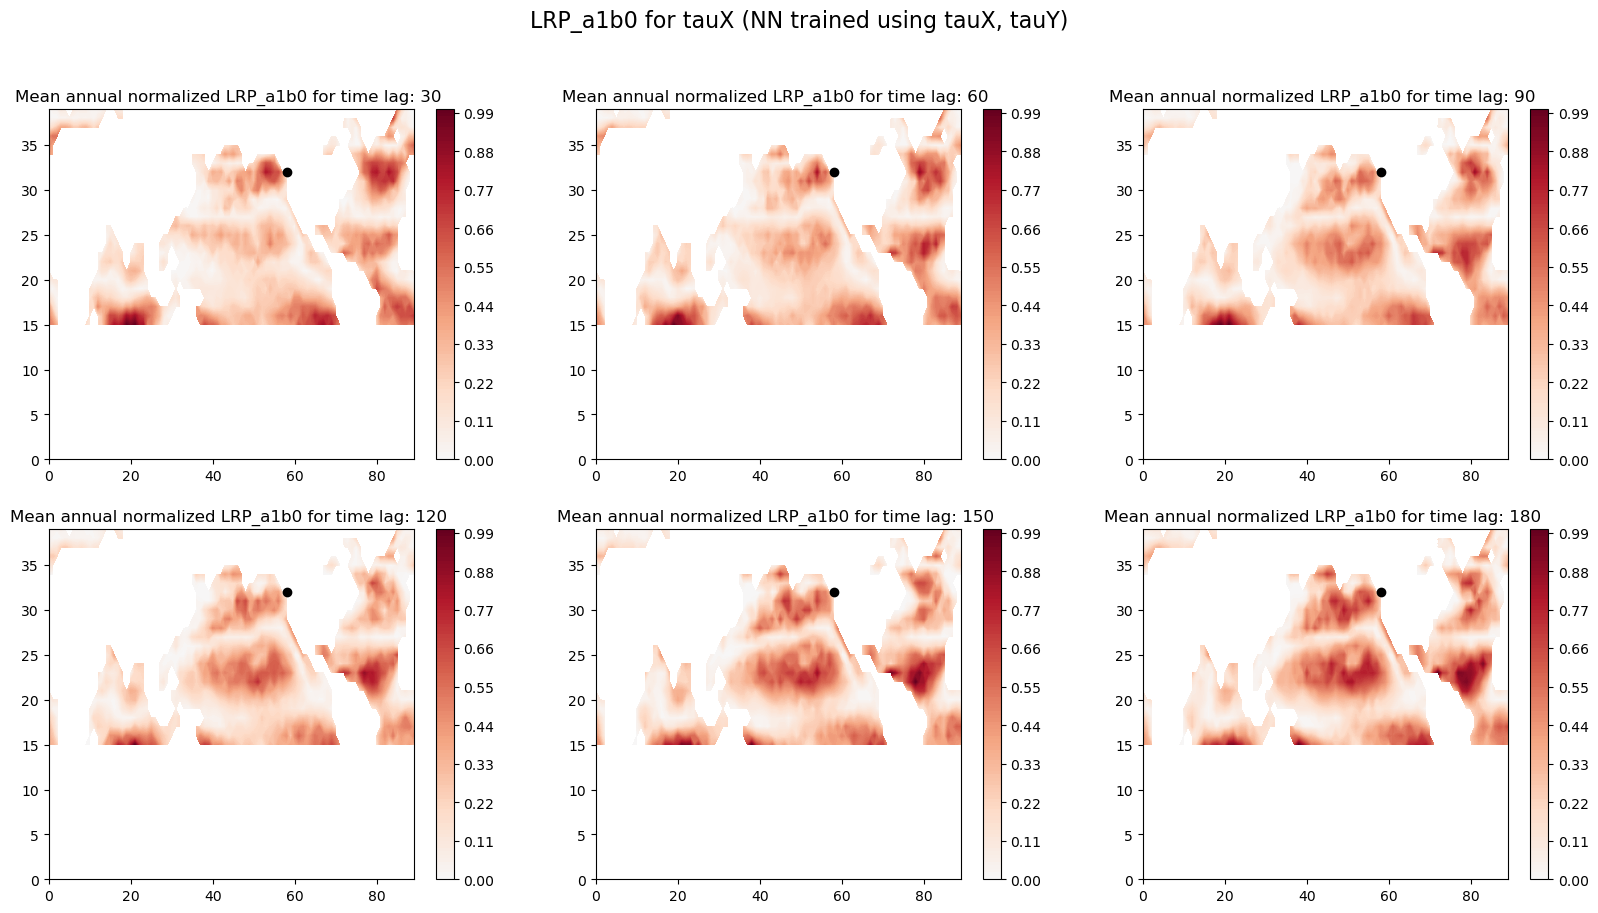

In [32]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_a1b0 for tauX (NN trained using tauX, tauY)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_tau[f'LRP{lagStepsList[i]}']['lrp.alpha_1_beta_0'][0], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_a1b0 for time lag: {lagStepsList[i]} ')

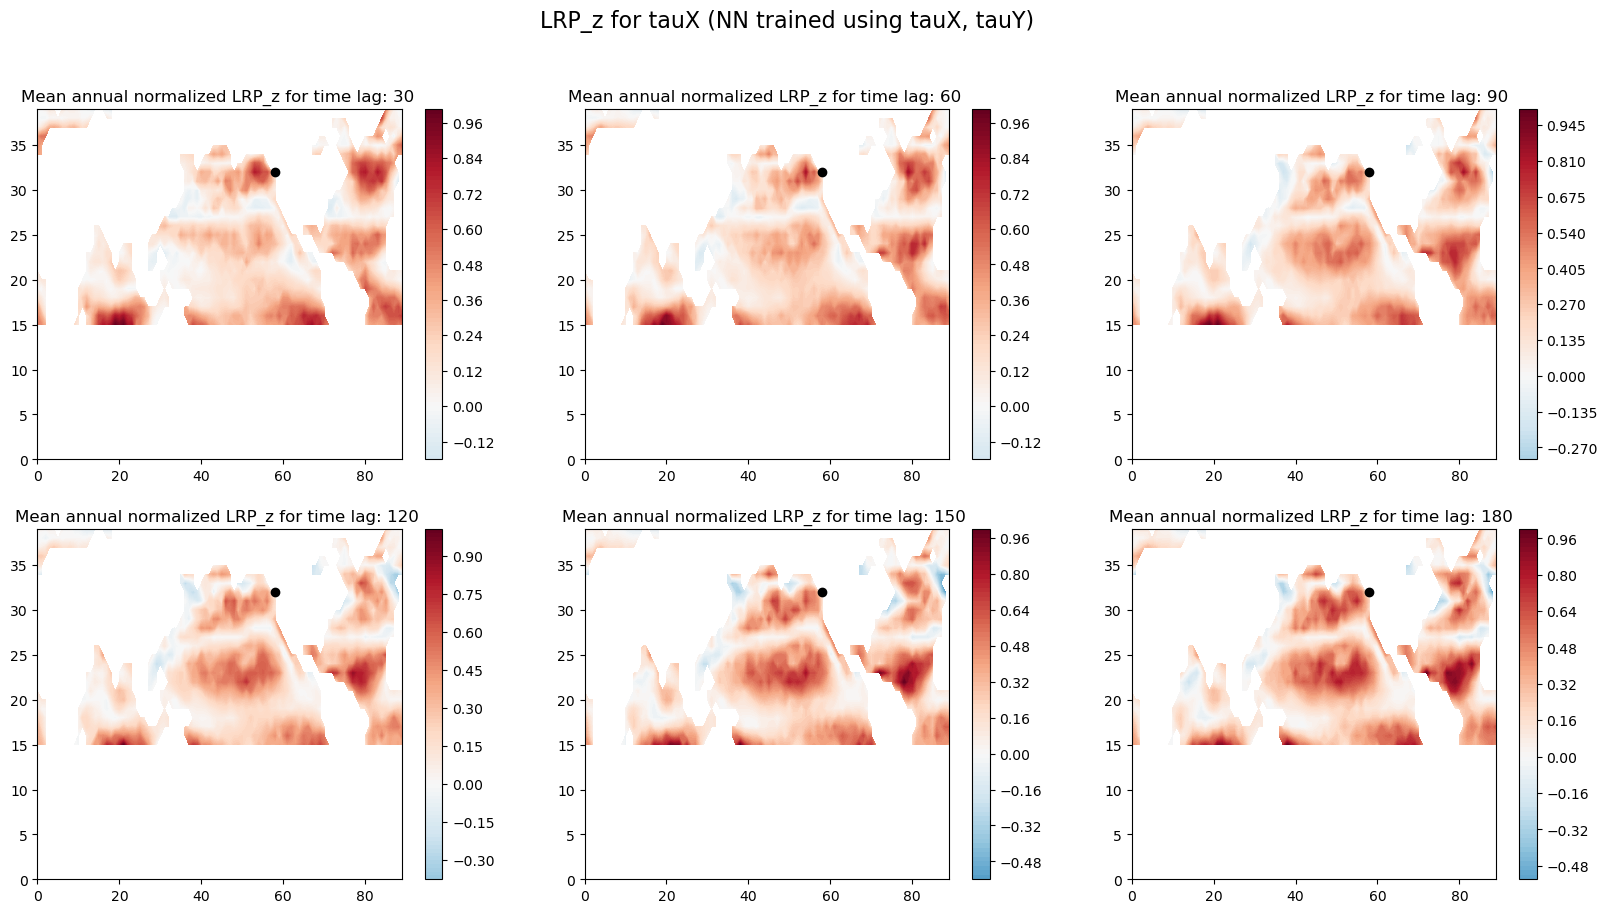

In [33]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_z for tauX (NN trained using tauX, tauY)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_tau[f'LRP{lagStepsList[i]}']['lrp.z'][0], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_z for time lag: {lagStepsList[i]} ')

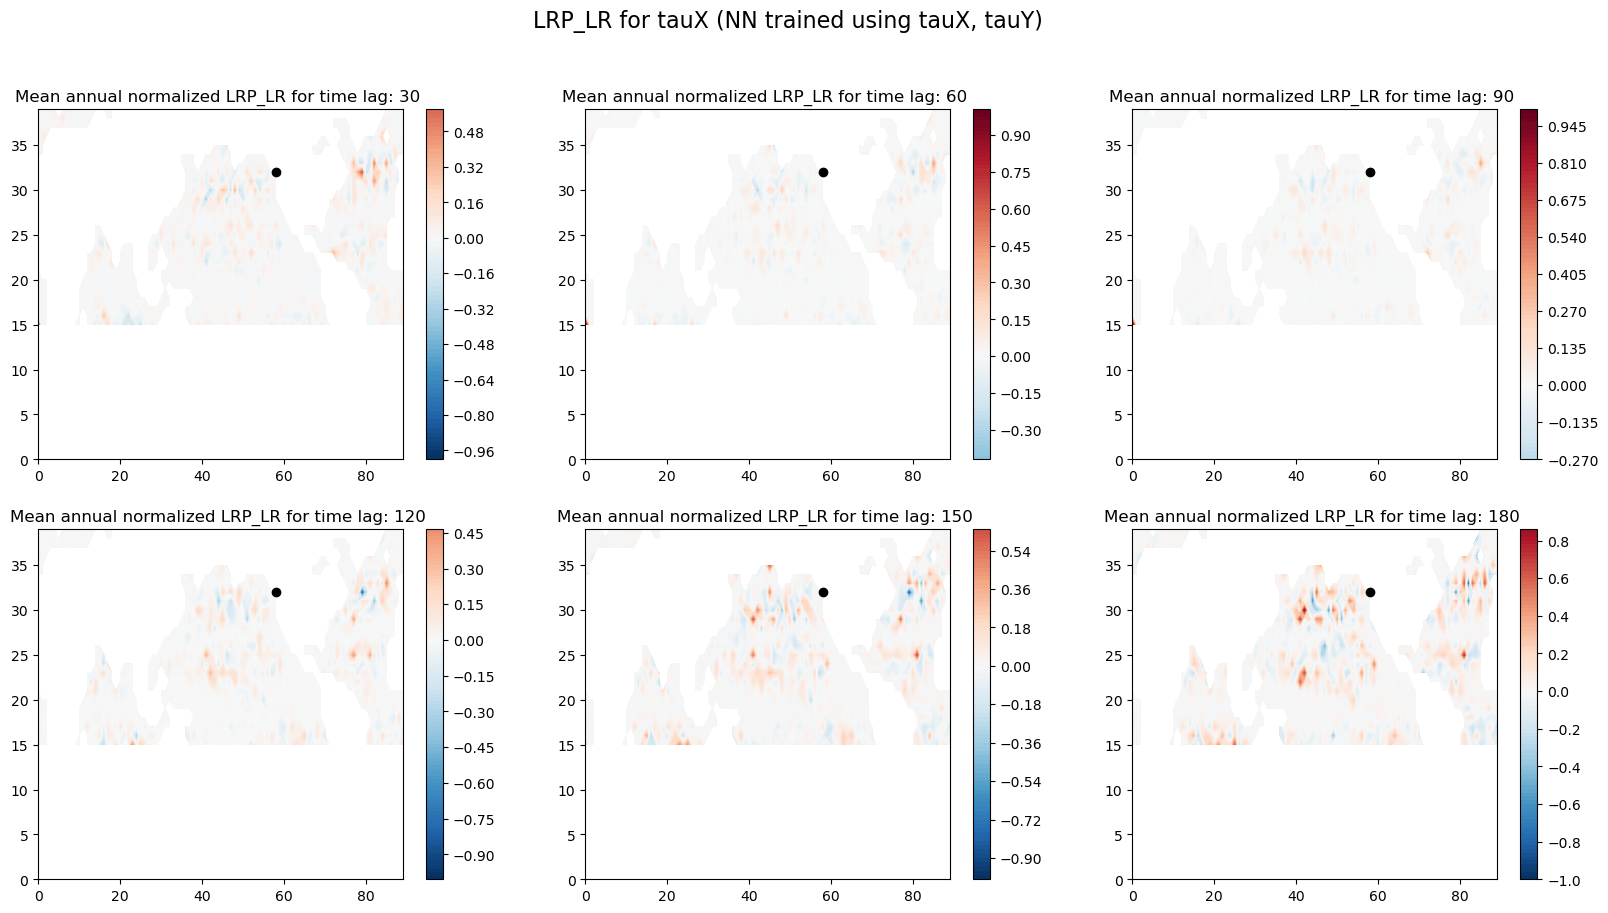

In [34]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_LR for tauX (NN trained using tauX, tauY)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_tau[f'LRP{lagStepsList[i]}']['lrp.LR'][0], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_LR for time lag: {lagStepsList[i]} ')

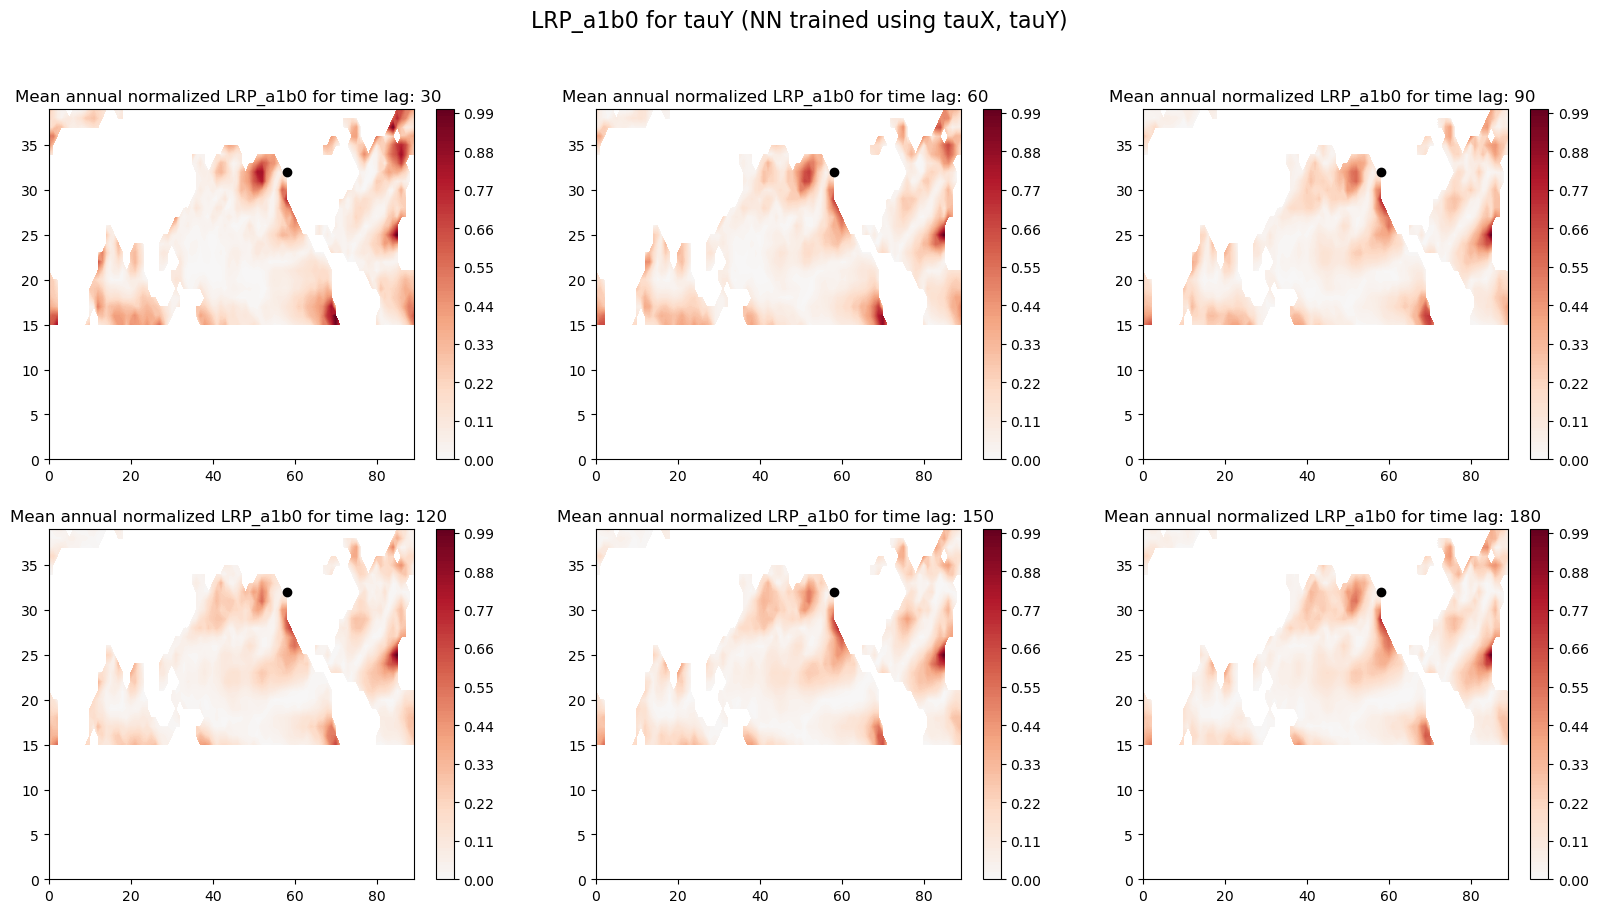

In [35]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_a1b0 for tauY (NN trained using tauX, tauY)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_tau[f'LRP{lagStepsList[i]}']['lrp.alpha_1_beta_0'][1], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_a1b0 for time lag: {lagStepsList[i]} ')

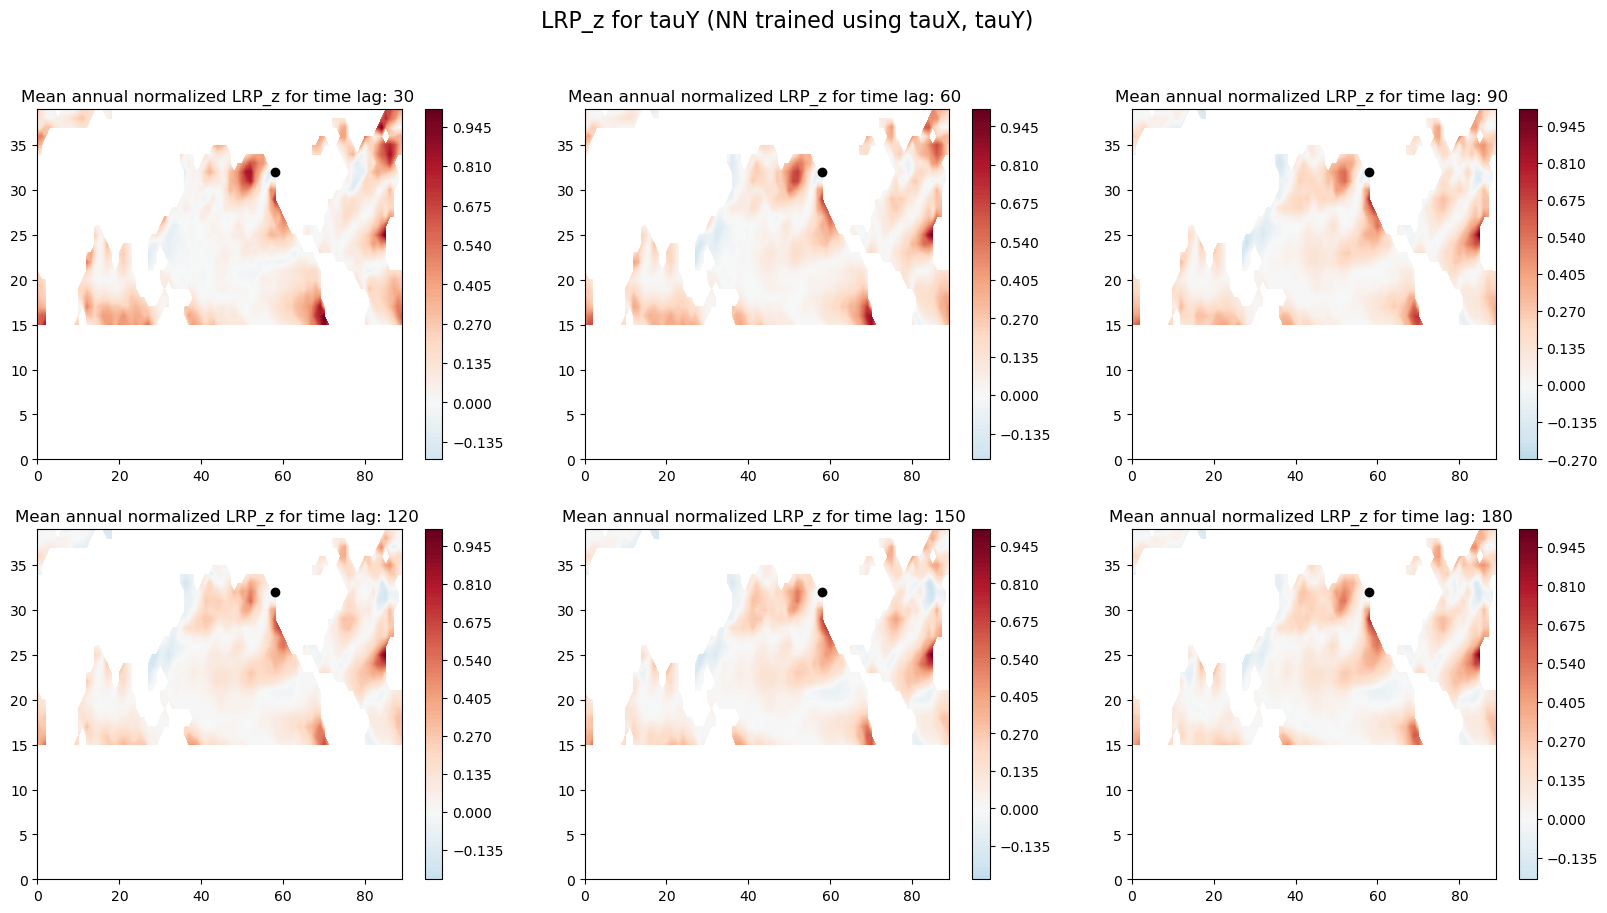

In [36]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_z for tauY (NN trained using tauX, tauY)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_tau[f'LRP{lagStepsList[i]}']['lrp.z'][1], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_z for time lag: {lagStepsList[i]} ')

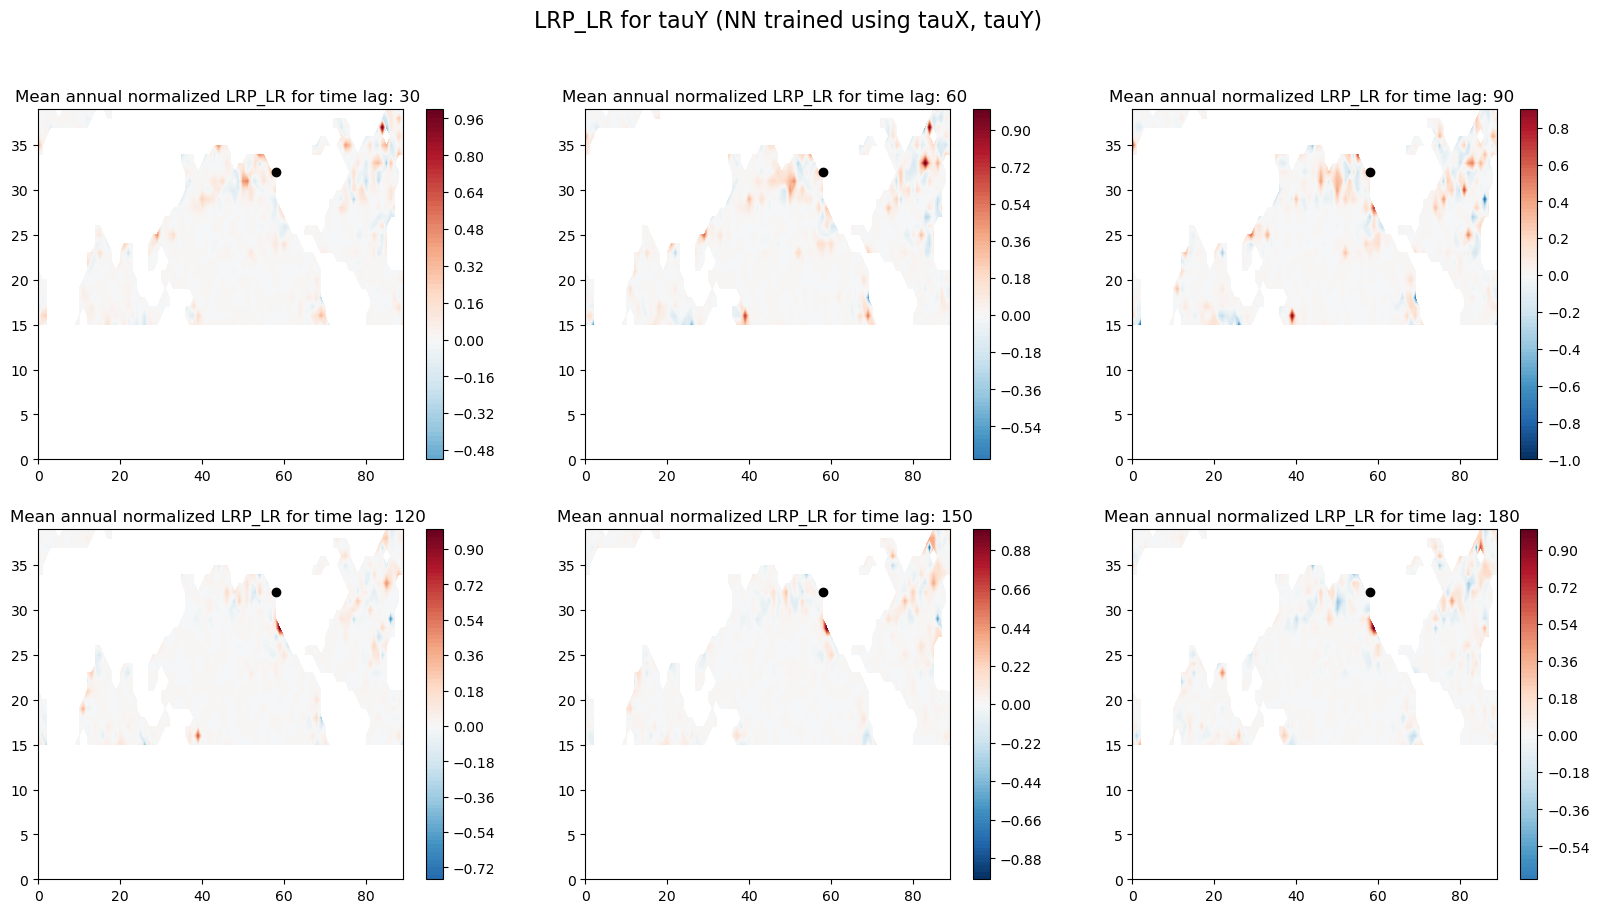

In [37]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2,3)
pltX = 0
pltY = 0
fig.suptitle('LRP_LR for tauY (NN trained using tauX, tauY)', fontsize=16)

for i in range(len(lagStepsList)):
    pltX = int(i/3)
    pltY = int(i%3)
    
    field = np.mean(LRPDict_tau[f'LRP{lagStepsList[i]}']['lrp.LR'][1], axis = 0)
    field = field / np.nanmax(np.abs(field))
    
    p = ax[pltX,pltY].contourf(field, vmin = -1, vmax = 1, levels = 100, cmap = 'RdBu_r')
    ax[pltX,pltY].scatter([58],[32], color = 'black')
    fig.colorbar(p, ax=ax[pltX,pltY])
    ax[pltX,pltY].set_title(f'Mean annual normalized LRP_LR for time lag: {lagStepsList[i]} ')